# Rolling PCA

Return matrix: (3008, 49) Date range: 2014-01-03 to 2025-12-18


/var/folders/h9/mp3w6nh50fx04f637tlzfwyc0000gn/T/ipykernel_41863/1582080275.py:51: RuntimeWarning: divide by zero encountered in matmul
  M = (Z.values.T @ Z.values) / (len(Z) - 1)   # correlation matrix
/var/folders/h9/mp3w6nh50fx04f637tlzfwyc0000gn/T/ipykernel_41863/1582080275.py:51: RuntimeWarning: overflow encountered in matmul
  M = (Z.values.T @ Z.values) / (len(Z) - 1)   # correlation matrix
/var/folders/h9/mp3w6nh50fx04f637tlzfwyc0000gn/T/ipykernel_41863/1582080275.py:51: RuntimeWarning: invalid value encountered in matmul
  M = (Z.values.T @ Z.values) / (len(Z) - 1)   # correlation matrix
/var/folders/h9/mp3w6nh50fx04f637tlzfwyc0000gn/T/ipykernel_41863/1582080275.py:51: RuntimeWarning: divide by zero encountered in matmul
  M = (Z.values.T @ Z.values) / (len(Z) - 1)   # correlation matrix
/var/folders/h9/mp3w6nh50fx04f637tlzfwyc0000gn/T/ipykernel_41863/1582080275.py:51: RuntimeWarning: overflow encountered in matmul
  M = (Z.values.T @ Z.values) / (len(Z) - 1)   # correlation 

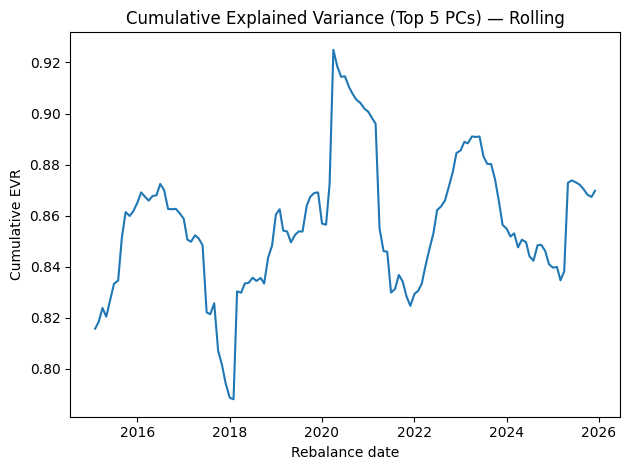

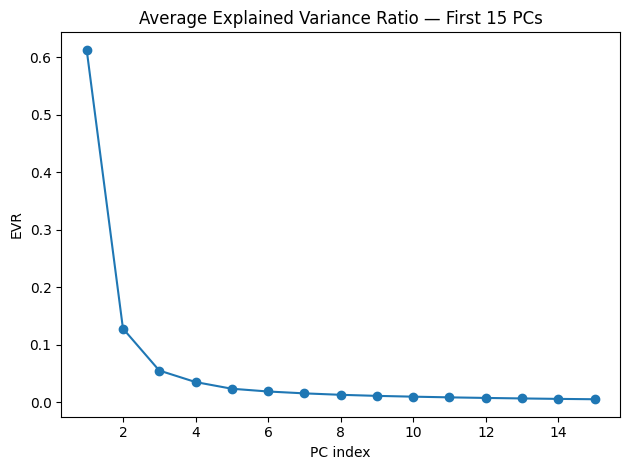

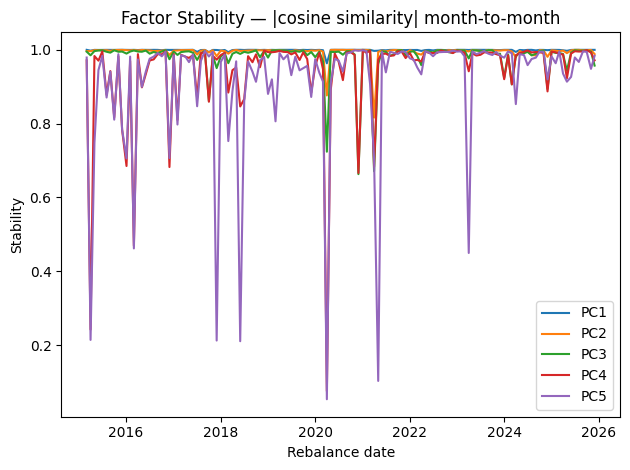

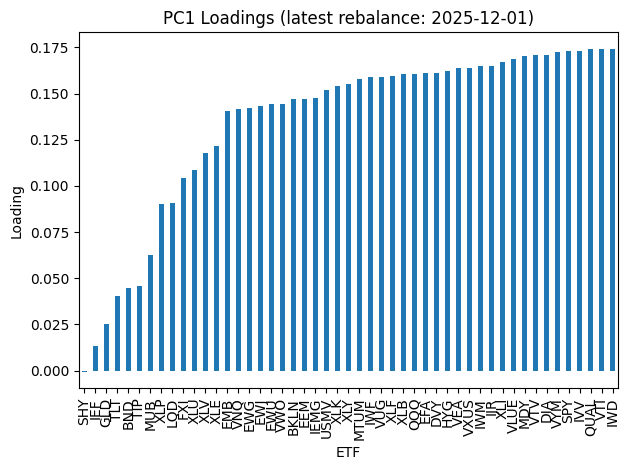


Saved Week 2 outputs to: /Users/jacobhahn/Desktop/QUANT PROJECT WINTER 2025 and figures to: /Users/jacobhahn/Desktop/QUANT PROJECT WINTER 2025
Latest rebalance date used: 2025-12-01
Average cumulative EVR (top K): 0.8563366226552305


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------
# Settings (Week 2 knobs)
# -------------------------
RETURNS_PATH = "/Users/jacobhahn/Desktop/QUANT PROJECT WINTER 2025/data_processed/returns_log.csv"
OUT_DIR = "/Users/jacobhahn/Desktop/QUANT PROJECT WINTER 2025"
FIG_DIR = "/Users/jacobhahn/Desktop/QUANT PROJECT WINTER 2025"

W = 252      # lookback window in trading days (~1 year)
K = 5        # number of PCs to track/study
USE_CORR = True  # True = PCA on correlation (standardized returns); False = PCA on covariance

os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

# -------------------------
# Load returns
# -------------------------
rets = pd.read_csv(RETURNS_PATH, index_col=0, parse_dates=True).sort_index()
tickers = rets.columns
N = len(tickers)

print("Return matrix:", rets.shape, "Date range:", rets.index.min().date(), "to", rets.index.max().date())

# Monthly rebalance dates = first trading day of each month
rebalance_dates = rets.groupby([rets.index.year, rets.index.month]).head(1).index

# -------------------------
# Rolling PCA loop
# -------------------------
dates_used = []
eigvals_list = []
eigvecs_list = []

for T in rebalance_dates:
    loc = rets.index.get_indexer([T])[0]
    if loc < W:
        continue

    window = rets.iloc[loc-W:loc]  # only past data (no look-ahead)

    # Build covariance or correlation
    X = window - window.mean(axis=0)  # demean
    if USE_CORR:
        s = X.std(axis=0, ddof=1).replace(0, np.nan)
        Z = (X / s).dropna(axis=1)
        M = (Z.values.T @ Z.values) / (len(Z) - 1)   # correlation matrix
    else:
        Xv = X.values
        M = (Xv.T @ Xv) / (len(X) - 1)               # covariance matrix

    # Symmetric eigendecomposition
    w, V = np.linalg.eigh(M)          # ascending
    idx = np.argsort(w)[::-1]         # descending
    w = w[idx]
    V = V[:, idx]

    dates_used.append(T)
    eigvals_list.append(w)
    eigvecs_list.append(V)

dates_used = pd.DatetimeIndex(dates_used)
eigvals = np.array(eigvals_list)      # shape: (T, N)
eigvecs = eigvecs_list                # list of (N,N) matrices

# -------------------------
# Explained variance ratios
# -------------------------
evr = eigvals / eigvals.sum(axis=1, keepdims=True)
evr_df = pd.DataFrame(evr[:, :max(15, K)], index=dates_used,
                      columns=[f"PC{k}" for k in range(1, max(15, K)+1)])

cum_evr_df = evr_df.iloc[:, :K].cumsum(axis=1)

evr_df.to_csv(os.path.join(OUT_DIR, "evr_by_rebalance.csv"))
cum_evr_df.to_csv(os.path.join(OUT_DIR, "cum_evr_by_rebalance.csv"))

# Plot 1: cumulative explained variance (top K) over time
plt.figure()
plt.plot(cum_evr_df.index, cum_evr_df.iloc[:, -1])
plt.title(f"Cumulative Explained Variance (Top {K} PCs) — Rolling")
plt.xlabel("Rebalance date")
plt.ylabel("Cumulative EVR")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "week2_cumulative_evr_topK.png"))
plt.show()

# Plot 2: average scree (first 15 PCs)
avg_evr = evr_df.iloc[:, :15].mean(axis=0)
plt.figure()
plt.plot(range(1, 16), avg_evr.values, marker="o")
plt.title("Average Explained Variance Ratio — First 15 PCs")
plt.xlabel("PC index")
plt.ylabel("EVR")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "week2_avg_scree_first15.png"))
plt.show()

# -------------------------
# Stability diagnostics
# -------------------------
# Because eigenvectors are sign-ambiguous, we align signs to previous month before computing similarity.
stability = np.full((len(dates_used), K), np.nan)

prev = None
for t in range(len(dates_used)):
    V = eigvecs[t][:, :K].copy()

    if prev is not None:
        for k in range(K):
            if np.dot(V[:, k], prev[:, k]) < 0:
                V[:, k] *= -1
            stability[t, k] = abs(np.dot(V[:, k], prev[:, k]))
    prev = V

stab_df = pd.DataFrame(stability, index=dates_used, columns=[f"PC{k}" for k in range(1, K+1)])
stab_df.to_csv(os.path.join(OUT_DIR, "stability_by_rebalance.csv"))

# Plot 3: PC stability over time
plt.figure()
for k in range(K):
    plt.plot(stab_df.index, stab_df.iloc[:, k], label=f"PC{k+1}")
plt.title("Factor Stability — |cosine similarity| month-to-month")
plt.xlabel("Rebalance date")
plt.ylabel("Stability")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "week2_pc_stability.png"))
plt.show()

# -------------------------
# Loadings: interpretability snapshot (latest rebalance)
# -------------------------
latest_V = eigvecs[-1][:, :K]
latest_date = dates_used[-1]

# PC1 loadings bar plot (latest)
pc1 = pd.Series(latest_V[:, 0], index=tickers).sort_values()
plt.figure()
pc1.plot(kind="bar")
plt.title(f"PC1 Loadings (latest rebalance: {latest_date.date()})")
plt.xlabel("ETF")
plt.ylabel("Loading")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "week2_pc1_loadings_latest.png"))
plt.show()

# Save top +/- loadings for PC1..PCK
rows = []
for k in range(K):
    v = pd.Series(latest_V[:, k], index=tickers)
    top_pos = v.sort_values(ascending=False).head(8)
    top_neg = v.sort_values().head(8)
    for name, val in top_pos.items():
        rows.append({"date": latest_date.date(), "pc": f"PC{k+1}", "sign": "positive", "ticker": name, "loading": float(val)})
    for name, val in top_neg.items():
        rows.append({"date": latest_date.date(), "pc": f"PC{k+1}", "sign": "negative", "ticker": name, "loading": float(val)})

pd.DataFrame(rows).to_csv(os.path.join(OUT_DIR, "top_loadings_latest.csv"), index=False)

print("\nSaved Week 2 outputs to:", OUT_DIR, "and figures to:", FIG_DIR)
print("Latest rebalance date used:", latest_date.date())
print("Average cumulative EVR (top K):", float(cum_evr_df.iloc[:, -1].mean()))
